In [2]:
import sys
cwd = "/Users/jordydikkers/personal/projects/machi-koro-ai"
sys.path.append(cwd)
import os
os.chdir(cwd)

In [3]:
import pickle
import torch
from buffer import Buffer, BigBuffer
import matplotlib.pyplot as plt
from env import GymMachiKoro, MachiKoro
from mcts_agent import MCTSAgent
import torch.nn as nn
import gym
import numpy as np


In [4]:
# for i in range(10):
#     with open(f"checkpoints/{i}.pkl", "rb") as file:
#         buffer = pickle.load(file)

#     buffer2 = BigBuffer(1, observation_space=buffer._observation_space, action_space=buffer._action_space)

#     buffer2.combine_buffers([buffer])
#     if buffer2._size != len(buffer2.obss):
#         a=1
#     with open(f"checkpoints2/{i}.pkl","wb") as file:
#         pickle.dump(buffer2, file)
    

In [5]:
# buffers = []
# for i in range(10):
#     with open(f"checkpoints/{i}.pkl", "rb") as file:
#         buffers.append(pickle.load(file))

# buffer = buffers[0].get_big_buffer()
# buffer.combine_buffers(buffers)

# buffer.compute_values()

In [99]:
with open(f"checkpoints/0.pkl", "rb") as file:
    buffer = pickle.load(file)

In [100]:
buffer.size

504

In [60]:
class PVNet(nn.Module):
    def __init__(
            self,
            observation_space: gym.Space,
            action_space: gym.Space,
    ):
        super().__init__()
        self.observation_space = observation_space
        self.action_space = action_space
        num_inputs = gym.spaces.flatten_space(observation_space).shape[0]
        num_outputs = action_space.n
        
        # self.fc1 = nn.Linear(num_inputs, 128)
        # self.fc2 = nn.Linear(128, 128)
        # self.fc3 = nn.Linear(128, num_outputs)

        # self.fc4 = nn.Linear(128, 64)
        # self.fc5 = nn.Linear(64, 1)

        self.fctrunk = nn.Linear(num_inputs, num_outputs)
        self.fclogits = nn.Linear(num_outputs, num_outputs)
        self.KLDiv = torch.nn.KLDivLoss(reduction="batchmean")

        self.fcvalue = nn.Linear(num_outputs, 1)

    def forward(self, x):
        # x = torch.relu(self.fc1(x))
        
        # x = torch.relu(self.fc2(x))
        # policy = self.fc3(x)
        # x = torch.relu(self.fc4(x))
        # value = torch.tanh(self.fc5(x))
        trunk = torch.relu(self.fctrunk(x))

        logits = self.fclogits(trunk)

        value = torch.tanh(self.fcvalue(trunk))
        # return policy, value
        return logits, value # torch.ones(self.action_space.n)/self.action_space.n

    def predict(self, observation):
        input = torch.tensor(gym.spaces.flatten(self.observation_space, observation)).unsqueeze(0).to(torch.float32)
        # policy_pred, value_pred = self.forward(input)
        value_pred = self.forward(input)

        # policy_pred = torch.nn.functional.softmax(policy_pred, 1)

        # return policy_pred.squeeze().detach().numpy(), value_pred.detach().numpy().item()
        return value_pred.detach().numpy().item()

    def loss_fn(self, policy_preds, value_preds, policy_targets, value_targets):
            policy_loss = self.KLDiv(torch.nn.functional.log_softmax(policy_preds), torch.tensor(policy_targets).to(torch.float32))
            value_loss = torch.nn.functional.mse_loss(value_preds, torch.tensor(value_targets).to(torch.float32))
            return value_loss + policy_loss

    def train(self, train_buffer, val_buffer, batch_size, epochs):
        
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)
        

        for epoch in range(epochs):
            train_batches = train_buffer.get_random_batches(batch_size = batch_size)

            tot_train_loss = 0
            train_steps_since_last_val_step = 0
            for i, batch in enumerate(train_batches):
                train_steps_since_last_val_step += 1
                obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, probs = batch
                
                # policy_preds, value_preds = self.forward(torch.tensor(obss).to(torch.float32))
                prob_preds, value_preds = self.forward(torch.tensor(obss).to(torch.float32))
                loss = self.loss_fn(
                    policy_preds=prob_preds,
                    value_preds=value_preds,
                    policy_targets=probs,
                    value_targets=values
                )
                tot_train_loss += loss
                if i % 100 == 0:
                    obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, probs = val_buffer[:]
                    # policy_preds, value_preds = self.forward(torch.tensor(obss).to(torch.float32))
                    prob_preds, value_preds = self.forward(torch.tensor(obss).to(torch.float32))
                    avg_val_loss = self.loss_fn(
                        policy_preds=prob_preds,
                        value_preds=value_preds,
                        policy_targets=probs,
                        value_targets=values
                    )
                    avg_train_loss = tot_train_loss/train_steps_since_last_val_step
                    print(f"epoch: {epoch} | train_loss: {avg_train_loss} | val_loss: {avg_val_loss}")
                    tot_train_loss = 0
                    train_steps_since_last_val_step = 0
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

In [50]:
env = MachiKoro(n_players=2)
env = GymMachiKoro(env)

pvnet = torch.load("checkpoints/0.pt") # PVNet(env.observation_space, env.action_space)

/var/folders/4k/zq7y_vc10hz_rjss8lkyh9640000gn/T/ipykernel_14746/367422964.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  policy_loss = self.KLDiv(torch.nn.functional.log_softmax(policy_preds), torch.tensor(policy_targets).to(torch.float32))


epoch: 0 | train_loss: 4.032174587249756 | val_loss: 4.385423183441162
epoch: 0 | train_loss: 2.824751615524292 | val_loss: 2.1298675537109375
epoch: 0 | train_loss: 1.9649063348770142 | val_loss: 1.783224105834961
epoch: 0 | train_loss: 1.7373710870742798 | val_loss: 1.630479335784912
epoch: 0 | train_loss: 1.6086175441741943 | val_loss: 1.6421010494232178
epoch: 1 | train_loss: 1.381392002105713 | val_loss: 1.5012056827545166
epoch: 1 | train_loss: 1.4917265176773071 | val_loss: 1.4127142429351807
epoch: 1 | train_loss: 1.4160865545272827 | val_loss: 1.3479375839233398
epoch: 1 | train_loss: 1.355027675628662 | val_loss: 1.3215842247009277
epoch: 1 | train_loss: 1.3356379270553589 | val_loss: 1.330898642539978
epoch: 2 | train_loss: 1.1591534614562988 | val_loss: 1.2621097564697266
epoch: 2 | train_loss: 1.2277785539627075 | val_loss: 1.205293893814087
epoch: 2 | train_loss: 1.1562464237213135 | val_loss: 1.1991138458251953
epoch: 2 | train_loss: 1.126023769378662 | val_loss: 1.12000

(array([4404., 1607., 1191.,  899.,  794.,  731.,  698.,  684.,  565.,
         463.,  467.,  427.,  423.,  359.,  397.,  330.,  356.,  231.,
         243.,  229.,  249.,  186.,  208.,  200.,  170.,  201.,  163.,
         150.,  168.,  175.,  147.,  154.,  153.,  126.,  135.,  137.,
         135.,  137.,  108.,  130.,  103.,   96.,  119.,  130.,  111.,
         148.,  132.,   99.,  105.,  113.,  121.,  115.,  135.,  125.,
         139.,  121.,  150.,  132.,  176.,  163.,  119.,  139.,  177.,
         180.,  141.,  158.,  202.,  170.,  187.,  195.,  242.,  220.,
         267.,  258.,  272.,  279.,  246.,  249.,  331.,  295.,  299.,
         437.,  362.,  345.,  357.,  351.,  346.,  390.,  416.,  394.,
         437.,  510.,  496.,  577.,  653.,  770.,  774.,  995., 1265.,
        3549.]),
 array([-1.        , -0.98000002, -0.95999998, -0.94      , -0.92000002,
        -0.89999998, -0.88      , -0.86000001, -0.83999997, -0.81999999,
        -0.80000001, -0.77999997, -0.75999999, -0.740000

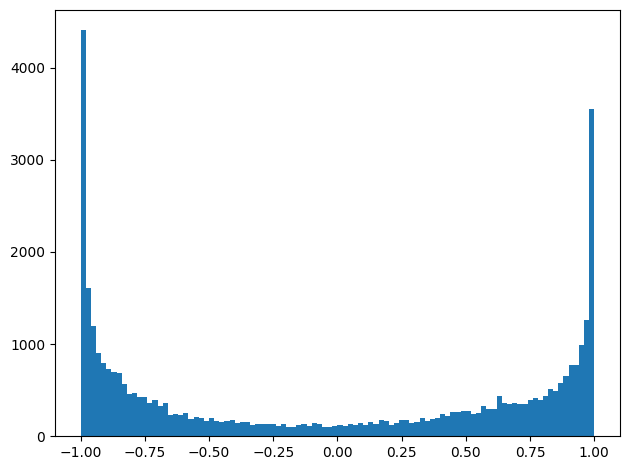

In [61]:
buffer.compute_values()
train_buffer, val_buffer = buffer.split_buffer(0.2)
pvnet = PVNet(env.observation_space, env.action_space)
pvnet.train(train_buffer=train_buffer, val_buffer=val_buffer, batch_size=64, epochs=5)

prob_preds, value_preds = pvnet.forward(torch.tensor(buffer.obss).to(torch.float32))

fig, axs = plt.subplots(1, 1, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs.hist(value_preds.detach().numpy().squeeze(), bins=100)

In [ ]:
# n=0
# for key, value in env.observation_space.items():
#     print(key, value, n)
#     if isinstance(value, gym.spaces.Box):
#         n += 1
#     else:
#         n += value.n

In [67]:
obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, probs = buffer[:]

In [69]:
len(obss), len(np.unique(obss))

(39313, 607)

In [70]:
len(next_obss), len(np.unique(next_obss))

(39313, 607)

In [90]:
np.unique(obss)

array([0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00,
       6.000e+00, 7.000e+00, 8.000e+00, 9.000e+00, 1.000e+01, 1.100e+01,
       1.200e+01, 1.300e+01, 1.400e+01, 1.500e+01, 1.600e+01, 1.700e+01,
       1.800e+01, 1.900e+01, 2.000e+01, 2.100e+01, 2.200e+01, 2.300e+01,
       2.400e+01, 2.500e+01, 2.600e+01, 2.700e+01, 2.800e+01, 2.900e+01,
       3.000e+01, 3.100e+01, 3.200e+01, 3.300e+01, 3.400e+01, 3.500e+01,
       3.600e+01, 3.700e+01, 3.800e+01, 3.900e+01, 4.000e+01, 4.100e+01,
       4.200e+01, 4.300e+01, 4.400e+01, 4.500e+01, 4.600e+01, 4.700e+01,
       4.800e+01, 4.900e+01, 5.000e+01, 5.100e+01, 5.200e+01, 5.300e+01,
       5.400e+01, 5.500e+01, 5.600e+01, 5.700e+01, 5.800e+01, 5.900e+01,
       6.000e+01, 6.100e+01, 6.200e+01, 6.300e+01, 6.400e+01, 6.500e+01,
       6.600e+01, 6.700e+01, 6.800e+01, 6.900e+01, 7.000e+01, 7.100e+01,
       7.200e+01, 7.300e+01, 7.400e+01, 7.500e+01, 7.600e+01, 7.700e+01,
       7.800e+01, 7.900e+01, 8.000e+01, 8.100e+01, 

In [ ]:
n_copies = np.zeros(len(obss))
for i in range(len(obss)):
    print(i)
    n_copies[i] = sum(np.equal(obss, obss[i]).all(1))

winning player: [0.]


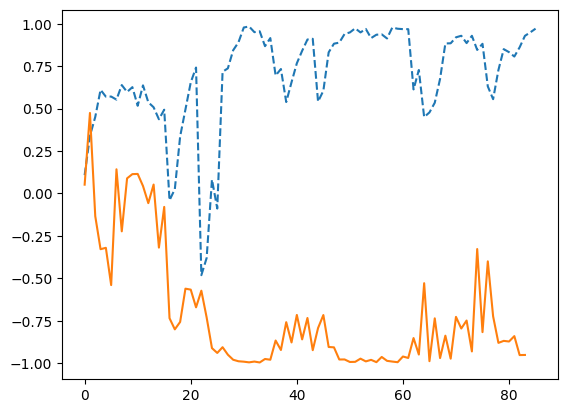

In [64]:
obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, probs = buffer.get_episode(1)
prob_preds, value_preds = pvnet.forward(torch.tensor(obss).to(torch.float32))
p0_indices, _ = np.where(player_ids == 0)
p1_indices, _  = np.where(player_ids == 1)
print(f"winning player: {player_ids[-1]}")
plt.plot(np.arange(len(p0_indices)), value_preds[p0_indices].detach().numpy(), "--")
plt.plot(np.arange(len(p1_indices)), value_preds[p1_indices].detach().numpy(), "-")
plt.show()

In [33]:
player_ids.flatten()[:10]

array([0., 0., 1., 1., 0., 0., 1., 1., 0., 0.])

In [35]:
value_preds.flatten()[:10]

tensor([ 0.9994,  0.9954, -0.8554,  0.7111,  0.9949,  0.9899, -0.9984, -0.9788,
         0.9988,  0.9937], grad_fn=<SliceBackward0>)

In [39]:
gym.spaces.utils.unflatten(env.observation_space, obss[1]), gym.spaces.utils.unflatten(env.observation_space, obss[2])

(OrderedDict([('current_player-Wheat Field',
               array([0, 1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Ranch',
               array([1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Flower Orchard',
               array([1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Forest',
               array([1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Mackerel Boat',
               array([1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Apple Orchard',
               array([1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Tuna Boat',
               array([1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-General Store',
               array([1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Bakery',
               array([0, 1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Demolition Company',
               array([1,